In [1]:
from netCDF4 import Dataset
from collections import defaultdict, namedtuple
import datetime
import numpy as np
import seaborn as sns
sns.set()
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import math
import os
import time
import csv
from statsmodels.tsa.stattools import pacf

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
month = '200607'

towmetds = Dataset('data/cabauw/cesar_tower_meteo_lc1_t10_v1.0_%s.nc' % month)
meteods = Dataset('data/cabauw/cesar_surface_meteo_lc1_t10_v1.0_%s.nc' % month)
fluxds = Dataset('data/cabauw/cesar_surface_flux_lc1_t10_v1.0_%s.nc' % month)
soilds = Dataset('data/cabauw/cesar_soil_heat_lb1_t10_v1.0_%s.nc' % month)

The Obukhov length is computed as follows (Hogstrom 1988):

$$
L=-\frac{u_*^3 T_0}{kg\overline{w'\theta_v}}
$$

where $u_*$ is the friction velocity, $T_0$ the surface temperature, $k$ the von Karman constant (approximately 0.4), $\theta_v$ the flux of potential virtual temperature, $g$ the gravitational constant.

We have

$$
\overline{w'\theta_v}=-\frac{H}{\rho_0 c_p}\left(1+0.07\frac{E\lambda}{H}\right)
$$

With $H$ being the turbulent sensible heat flux and $L\lambda$ the turbulent latent heat flux, $\rho$ the air density, $c_p$ the specific heat. The specific heat is a function of temperature, but between 250 and 350 K it takes values between 1003 and 1008 J/kg.K, thus we can assume it constant at 1005.

The air density can be derived using the ideal gas law:

$$
\rho=\frac{P}{RT_0}
$$

with $P$ the surface pressure in Pascal, $T_0$ the surace temperature in Kelvin, and $R$ the specific gas constant. For dry air, $R=287.058$ J/kg.K, and varies slightly depending on the composition of air (e.g. moisture) TODO does it matter?

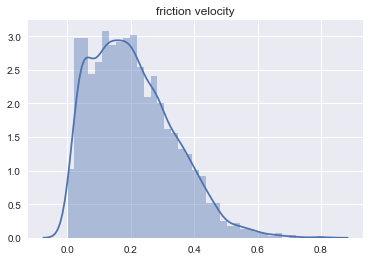

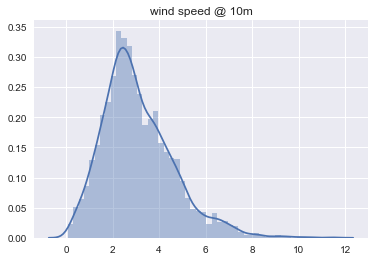

In [3]:
sns.distplot(fluxds['UST'][:])
plt.title('friction velocity')
plt.show()

sns.distplot(towmetds['F'][:, -2])
plt.title('wind speed @ 10m')
plt.show()

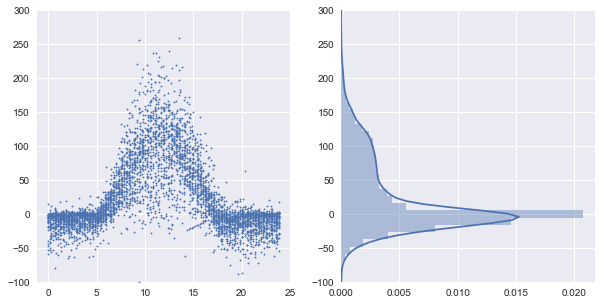

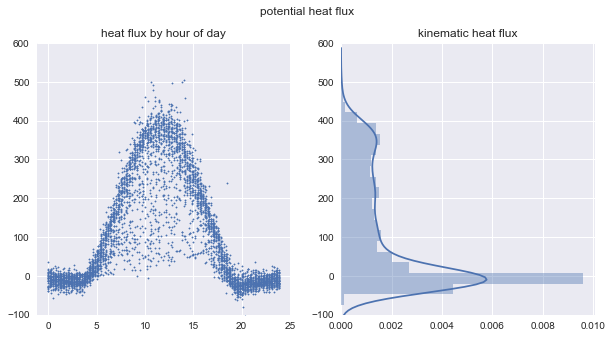

In [4]:
plt.figure(figsize=(10, 5))
plt.title('kinematic heat flux')
plt.subplot(1, 2, 1)
plt.scatter(fluxds['time'][:] % 24, fluxds['H'][:], s=2)
plt.ylim(-100, 300)
plt.subplot(1, 2, 2)
sns.distplot(fluxds['H'][:], vertical=True)
plt.ylim(-100, 300)
plt.show()

plt.figure(figsize=(10, 5))
plt.suptitle('potential heat flux')
plt.subplot(1, 2, 1)
plt.title('heat flux by hour of day')
plt.scatter(fluxds['time'][:] % 24, fluxds['LE'][:], s=2)
plt.ylim(-100, 600)
plt.subplot(1, 2, 2)
sns.distplot(fluxds['LE'][:], vertical=True)
plt.title('kinematic heat flux')
plt.ylim(-100, 600)
plt.show()

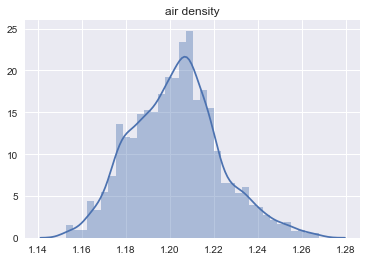

In [5]:
air_density = 100 * meteods['P0'][:] / (287.058 * (273.15 + meteods['TA002'][:]))

sns.distplot(air_density)
plt.title('air density')
plt.show()

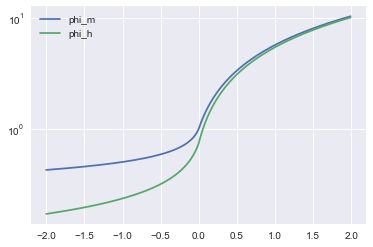

In [6]:
def phi_m(zL):
    if zL < 0:
        return math.pow(1 - 15 * zL, -0.25)
    else:
        return 1 + 4.7 * zL

    
def phi_h(zL):
    if zL < 0:
        return 0.74 * math.pow(1 - 9 * zL, -0.5)
    else:
        return 0.74 + 4.7 * zL


xx = np.arange(-2, 2, 0.01)
ym = list(map(phi_m, xx))
yh = list(map(phi_h, xx))
plt.plot(xx, ym, label='phi_m')
plt.plot(xx, yh, label='phi_h')
plt.yscale('log')
plt.legend()
plt.show()

wind and temperature profile

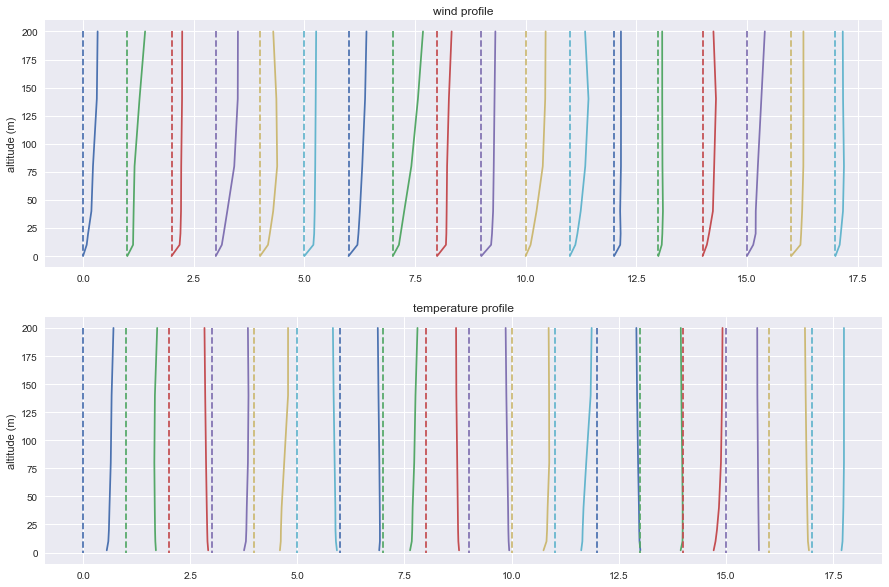

In [7]:
plt.figure(figsize=(15, 5))


fig, (ax1, ax2) = plt.subplots(2, 1)
fig.set_size_inches(15, 10)

ax1.set_title('wind profile')
ax1.set_ylabel('altitude (m)')

ax2.set_title('temperature profile')
ax2.set_ylabel('altitude (m)')

for i, tt in enumerate(towmetds['time'][::250]):
    ws = towmetds['F'][tt][:-1]
    qq = ax1.plot([i + w / 20 for w in ws] + [i], list(towmetds['z'][:-1]) + [0], 'x-')
    ax1.plot([i, i], [200, 0], '--', c=qq[0]._color)
    
    ts = towmetds['TA'][tt]
    qq = ax2.plot([i + (t - 273.15) / 30 for t in ts], towmetds['z'][:], 'x-')
    ax2.plot([i, i], [200, 0], '--', c=qq[0]._color)

plt.show()

wind/temperature profile gradient, obtained by weight averaging top and bottom derivatives (quantity is $x$ and altitude is $y$). Let $\Delta^+a_i=a_{i+1}-a_i$ and $\Delta^-a_i=a_i-a_{i-1}$, then

\begin{align*}
\frac{\partial x_i}{\partial y_i}
&=\frac{\Delta^+x_i}{\Delta^+y_i}\cdot\frac{\Delta^+y_i}{\Delta^+y_i+\Delta^-y_i}
+\frac{\Delta^-x_i}{\Delta^-y_i}\cdot\frac{\Delta^-y_i}{\Delta^+y_i+\Delta^-y_i} \\
&=\frac{\Delta^+x_i+\Delta^-x_i}{\Delta^+y_i+\Delta^-y_i} \\
&= \frac{x_{i+1}-x_{i-1}}{y_{i+1}-y_{i-1}}
\end{align*}

for boundary values we can only use the previous/next measurement

$$
\frac{\partial x_0}{\partial y_0}=\frac{x_1-x_0}{y_1-y_0}
$$

~~we fill missing values with linear interpolation. this will result in the same gradient, but at least we won't throw away the value~~

we cannot use linear interpolation to fill the value, because the wind profile is not linear, and cannot be approximated like that. instead, we simply skip the value

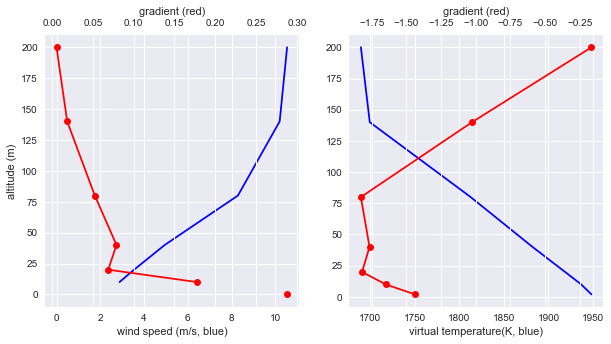

In [8]:
def get_derivative(xs, ys):
    # we assume xs are all valid, since they are the levels
    gxs, gys = zip(*[
        (x, y) for x, y in zip(xs, ys) 
        if np.isfinite(y)
    ])

    gdydx = []
    for i in range(len(gxs)):
        if i == 0:
            d = (gys[i] - gys[i + 1]) / (gxs[i] - gxs[i + 1])
        elif i == len(gxs) - 1:
            d = (gys[i - 1] - gys[i]) / (gxs[i - 1] - gxs[i])
        else:
            d = (gys[i - 1] - gys[i + 1]) / (gxs[i - 1] - gxs[i + 1])

        gdydx.append(d)
        
    i, dydx = 0, []
    for x, y in zip(xs, ys):
        if np.isfinite(y):
            dydx.append(gdydx[i])
            i += 1
        else:
            dydx.append(np.nan)

    return dydx


def get_wind_profile(time_index, towmetds):
    ws = list(
        np.nan if towmetds['F'][time_index].mask[i] else wind
        for i, wind in enumerate(towmetds['F'][time_index].data)
    )

    zs = list(towmetds['z'][:])

    # no-slip condition
    ws.append(0)
    zs.append(0)
    
    dwdz = get_derivative(zs, ws)
    return zs, ws, dwdz


def get_temperature_profile(tt, towmetds, soilds):
    zs = list(towmetds['z'][:])

    virtual_temp = [
        temp * (1 + 0.61 * spec_hum)
        for temp, spec_hum in zip(
            towmetds['TA'][time_index][:], towmetds['Q'][time_index][:]
        )
    ]

    dtdz = get_derivative(zs, virtual_temp)
    return zs, virtual_temp, dtdz


tt = 126

wz, ws, dwdz = get_wind_profile(tt, towmetds)
tz, ts, dtdz = get_temperature_profile(tt, towmetds, soilds)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(10, 5)

ax1.set_ylabel('altitude (m)')
ax1.plot(ws, wz, 'x-', c='b')
ax1.set_xlabel('wind speed (m/s, blue)')
ax12 = ax1.twiny()
ax12.plot(dwdz, wz, 'o-', c='r')
ax12.set_xlabel('gradient (red)')

ax2.plot(ts, tz, 'x-', c='b')
ax2.set_xlabel('virtual temperature(K, blue)')
ax22 = ax2.twiny()
ax22.plot(dtdz, tz, 'o-', c='r')
ax22.set_xlabel('gradient (red)')

plt.show()

experimental wind shear is computed as

$$
\phi_m\left(\frac{z}{L}\right)=\frac{kz}{u_*}\frac{\partial \overline{U}}{\partial z}
$$

with $\overline{U}$ the average wind speed.

experimental temperature gradient is

$$
\phi_h\left(\frac{z}{L}\right)=
\frac{kz}{\theta_*}\frac{\partial\overline\Theta}{\partial z}=
-\frac{kzu_*c_p\rho}{\overline{w^\prime\Theta_{v_0}^\prime}}\frac{\partial\overline\Theta}{\partial z}
$$

with $\overline{w^\prime\Theta_{v_0}^\prime}$ being the turbulent surface kinematic heat flux and $\theta_*=-\overline{w^\prime\Theta_{v_0}^\prime}/(u_*c_p\rho)$

In [9]:
measurement_cols = ['air_dens', 'H', 'LE', 'ustar', 'wind', 'temp', 'virtual_temp', 'soil_temp', 'z']
index_cols = ['ds', 'year', 'month', 'daym', 'hday', 'tt', 'datetime', 'minute']
computed_cols = ['phi_m', 'phi_h', 'zL', 'dwdz', 'dtdz', 'lval']
source_cols = ['IUST', 'ILE', 'IH', 'ITA', 'IF', 'IP0']
additional_cols = ['dewpoint', 'spec_hum', 'rel_hum', 'press', 'rain', 'co2flux', 'soilheat', 'netrad']
RowRecord = namedtuple('RowRecord', index_cols + measurement_cols + computed_cols + source_cols + additional_cols)


def process(month):
    try:
        towmetds = Dataset('data/cabauw/cesar_tower_meteo_lc1_t10_v1.0_%s.nc' % month)
        meteods = Dataset('data/cabauw/cesar_surface_meteo_lc1_t10_v1.0_%s.nc' % month)
        fluxds = Dataset('data/cabauw/cesar_surface_flux_lc1_t10_v1.0_%s.nc' % month)
    except:
        import traceback
        print('while loading data for', month)
        traceback.print_exc()
        return

    try:
        soilds = Dataset('data/cabauw/cesar_soil_heat_lb1_t10_v1.0_%s.nc' % month)
    except:
        soilds = None

    for time_index, tt in enumerate(towmetds['time']):
        wz, ws, dwdz = get_wind_profile(time_index, towmetds)
        tz, ts, dtdz = get_temperature_profile(time_index, towmetds, soilds)

        # fill missing top/bottom levels with nan
        levels = [200., 140., 80., 40., 20., 10., 2., 0.]
        tz_full, ts_full, dtdz_full = [], [], []
        wz_full, ws_full, dwdz_full = [], [], []
        iw = it = 0
        for i, lvl in enumerate(levels):
            tz_full.append(lvl)
            if it < len(tz) and abs(tz[it] - lvl) < 1:
                ts_full.append(ts[it])
                dtdz_full.append(dtdz[it])
                it += 1
            else:
                ts_full.append(np.nan)
                dtdz_full.append(np.nan)

            wz_full.append(lvl)
            if iw < len(wz) and abs(wz[iw] - lvl) < 1:
                ws_full.append(ws[iw])
                dwdz_full.append(dwdz[iw])
                iw += 1
            else:
                ws_full.append(np.nan)
                dwdz_full.append(np.nan)
        
        # compute L, z/L, phi_m and phi_h for each level
        for alt_index, (z, wind, vtemp, dwind, dtemp) in enumerate(zip(wz, ws, ts, dwdz, dtdz)):
            if z > 50 or z < 2: # outside of the surface layer
                continue

            spec_hum = towmetds['Q'][time_index, alt_index]
            air_dens = 100 * meteods['P0'][time_index] / (287.058 * vtemp)  # kg.m-3

            virtual_potential_temperature_flux = (
                fluxds['H'][time_index] + 0.07 * fluxds['LE'][time_index]
            ) / (1005 * air_dens)

            lval = -fluxds['UST'][time_index]**3 * vtemp / (
                0.4 * 9.81 * virtual_potential_temperature_flux
            )  # m

            phi_m = dwind * 0.4 * z / fluxds['UST'][time_index]
            phi_h = -(
                dtemp * 0.4 * z * fluxds['UST'][time_index]
                / virtual_potential_temperature_flux
            )

            daym = int(tt / 24)
            hday = tt % 24
            minute = 60 * (hday - int(hday))
            second = 60 * (minute - int(minute))

            dt = datetime.datetime(
                year=int(month[:4]), month=int(month[4:]), day=int(daym) + 1,
                hour=int(hday), minute=int(minute), second=int(second)
            )

            yield RowRecord(
                ds=month,
                tt=tt,
                year=dt.year,
                month=dt.month,
                daym=dt.day,
                hday=dt.hour,
                minute=dt.minute,
                datetime=time.mktime(dt.timetuple()),

                air_dens=air_dens,
                H=fluxds['H'][time_index],
                LE=fluxds['LE'][time_index],
                ustar=fluxds['UST'][time_index],
                temp=towmetds['TA'][time_index, alt_index],
                virtual_temp=vtemp,
                soil_temp=(273.15 + soilds['TS00'][time_index]) if soilds else np.nan,
                wind=wind,

                z=z,
                lval=lval,
                zL=z / lval,
                dwdz=dwind,
                dtdz=dtemp,
                phi_m=phi_m,
                phi_h=phi_h,

                IUST=fluxds['IUST'][time_index],
                ILE=fluxds['ILE'][time_index],
                IH=fluxds['IH'][time_index],
                ITA=towmetds['ITA'][time_index, alt_index],
                IF=towmetds['IF'][time_index, alt_index],
                IP0=meteods['IP0'][time_index],

                co2flux=fluxds['FC'][time_index],
                soilheat=fluxds['G0'][time_index],
                netrad=fluxds['QN'][time_index],
                spec_hum=spec_hum,
                dewpoint=towmetds['TD'][time_index, alt_index],
                rel_hum=towmetds['RH'][time_index, alt_index],
                press=meteods['P0'][time_index],
                rain=meteods['RAIN'][time_index],
            )

In [10]:
dframe_path = 'data/cabauw/processed.csv.gz'

if not os.path.exists(dframe_path):
    print('recomputing data (you take a coffee)')
    import findspark
    findspark.init()

    from pyspark import SparkContext, SparkConf

    sc = SparkContext(conf=SparkConf()
        .setMaster('local[7]')
        .set('spark.driver.memory', '14g')
        .set('spark.driver.maxResultSize', '14g'))
    all_months = set(f[-6-3:-3] for f in os.listdir('data/cabauw') if f.endswith('.nc'))

    bad_rows = sc.accumulator(0)    
    def good_row(row):
        is_good = row.ustar > 0.1 and abs(row.H) > 10 and row.wind > 1
        if not is_good:
            bad_rows.add(1)
        return is_good

    try:
        df_rows = (sc.parallelize(all_months, len(all_months))
            .flatMap(process)
            .filter(good_row)
            .collect())
    finally:
        sc.stop()

    print(bad_rows.value, 'rows had bad data')
    print('collected', len(df_rows), 'rows of good data')

    df = pd.DataFrame(df_rows)
    df.to_csv(dframe_path, index=False)


try:
    df = pd.read_csv(dframe_path, na_values='--')
except (OSError, UnicodeDecodeError):
    df = pd.read_csv(dframe_path, na_values='--', compression='gzip')

print(len(df), 'recods')

1561973 recods


got 1996555 bad rows

we also remove data from 201603 as it contains bad measurements for the fluxes

In [11]:
df[df.ds == 201603][['H', 'LE']].describe().T

,count,mean,std,min,25%,50%,75%,max
H,9553.0,314.313909,6980.719147,-1552.988037,-46.030830,-14.380824,36.903568,287641.1250
LE,9522.0,46.359942,252.483067,-9660.833000,-17.214043,34.001152,120.266309,1549.6664


In [12]:
df = df[df.ds != 201603]
print(len(df), 'good records')

1552420 good records


In [13]:
df[additional_cols].describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
dewpoint,1547882.0,280.300422,6.099103,187.966110,276.618870,280.643280,284.576320,296.747620
spec_hum,1552420.0,6.616596,2.452218,-0.944752,4.806394,6.349312,8.281773,17.782124
rel_hum,1547882.0,76.561500,15.201796,0.003741,66.956353,79.173755,88.266014,133.698460
press,1552420.0,1014.220861,9.871962,960.900024,1008.400024,1014.900024,1020.799988,1046.400024
rain,1552420.0,0.016059,0.124347,-0.016667,0.000000,0.000000,0.000000,15.100000
co2flux,1552420.0,-0.064074,0.295426,-7.483615,-0.245182,0.032629,0.116055,6.102142
soilheat,1552420.0,2.867279,15.572178,-77.832718,-6.476648,-0.719930,8.811345,1138.953857
netrad,1552420.0,81.474677,167.152922,-158.464615,-35.447525,-3.014862,171.792969,7775.445312


In [14]:
df[measurement_cols].describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
air_dens,1552420.0,0.275836,0.122575,0.100890,0.201929,0.254193,0.320078,2.833936
H,1552420.0,3.596985,47.269160,-459.999756,-25.835962,-14.769259,28.045113,479.642334
LE,1552420.0,74.574124,114.854946,-534.843600,-4.975750,23.663866,132.413420,6940.750000
ustar,1552420.0,0.308110,0.147369,0.100000,0.198330,0.281670,0.385867,1.848029
wind,1552420.0,5.856784,2.649183,1.000041,3.980000,5.426778,7.229194,29.387110
temp,1552420.0,284.701992,6.400130,259.649994,280.149994,284.750000,289.350006,306.850006
virtual_temp,1552420.0,1441.632612,454.425105,124.793505,1103.014656,1388.263242,1749.555893,3506.047302
soil_temp,1304764.0,284.326381,5.650719,271.882630,279.602430,284.218900,289.057431,302.586436
z,1552420.0,23.336230,12.472362,10.000000,10.000000,20.000000,40.000000,40.000000


In [15]:
df[computed_cols].describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
phi_m,1552420.0,2.636120,1.846761,-7.055784e+00,1.075840,2.432656,3.848667,1.654241e+01
phi_h,1552420.0,-4.056675,1884.317810,-1.237893e+06,-14.603637,0.629083,11.456082,9.898927e+05
zL,1552420.0,-0.086009,2.249568,-1.191422e+02,-0.253047,0.069770,0.399059,3.343907e+01
dwdz,1552420.0,0.125621,0.138939,-9.733333e-02,0.035625,0.061461,0.200825,1.384500e+00
dtdz,1552420.0,-0.887779,3.677948,-1.388861e+02,-1.208824,-0.515082,-0.106465,1.460228e+02
lval,1552420.0,112.172597,5874.877920,-1.148571e+06,-22.094067,22.700730,120.320426,3.496107e+06


In [16]:
df[index_cols].describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
ds,1552420.0,2.008975e+05,4.881996e+02,200101.0,2.005030e+05,2.009050e+05,2.013090e+05,2.017120e+05
year,1552420.0,2.008910e+03,4.881137e+00,2001.0,2.005000e+03,2.009000e+03,2.013000e+03,2.017000e+03
month,1552420.0,6.424853e+00,3.419170e+00,1.0,4.000000e+00,6.000000e+00,9.000000e+00,1.200000e+01
daym,1552420.0,1.565950e+01,8.809076e+00,1.0,8.000000e+00,1.600000e+01,2.300000e+01,3.100000e+01
hday,1552420.0,1.163536e+01,6.537744e+00,0.0,7.000000e+00,1.200000e+01,1.700000e+01,2.300000e+01
tt,1552420.0,3.638802e+02,2.115231e+02,0.0,1.805000e+02,3.615000e+02,5.453334e+02,7.438334e+02
datetime,1552420.0,1.243418e+09,1.545008e+08,978303600.0,1.110316e+09,1.241820e+09,1.378071e+09,1.514761e+09
minute,1552420.0,2.490446e+01,1.705664e+01,0.0,1.000000e+01,3.000000e+01,4.000000e+01,5.000000e+01


In [17]:
df[source_cols].describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
IUST,1552420.0,2.254951,0.686953,2.0,2.0,2.0,2.0,7.0
ILE,1552420.0,2.459457,1.281570,2.0,2.0,2.0,2.0,7.0
IH,1552420.0,2.411393,1.203921,2.0,2.0,2.0,2.0,7.0
ITA,1552420.0,2.043940,0.436625,2.0,2.0,2.0,2.0,7.0
IF,1552420.0,2.025575,0.338275,2.0,2.0,2.0,2.0,7.0
IP0,1552420.0,3.031298,0.346980,3.0,3.0,3.0,3.0,7.0


plot correlation matrix between data, computed values, and time of year (to check seasonality)

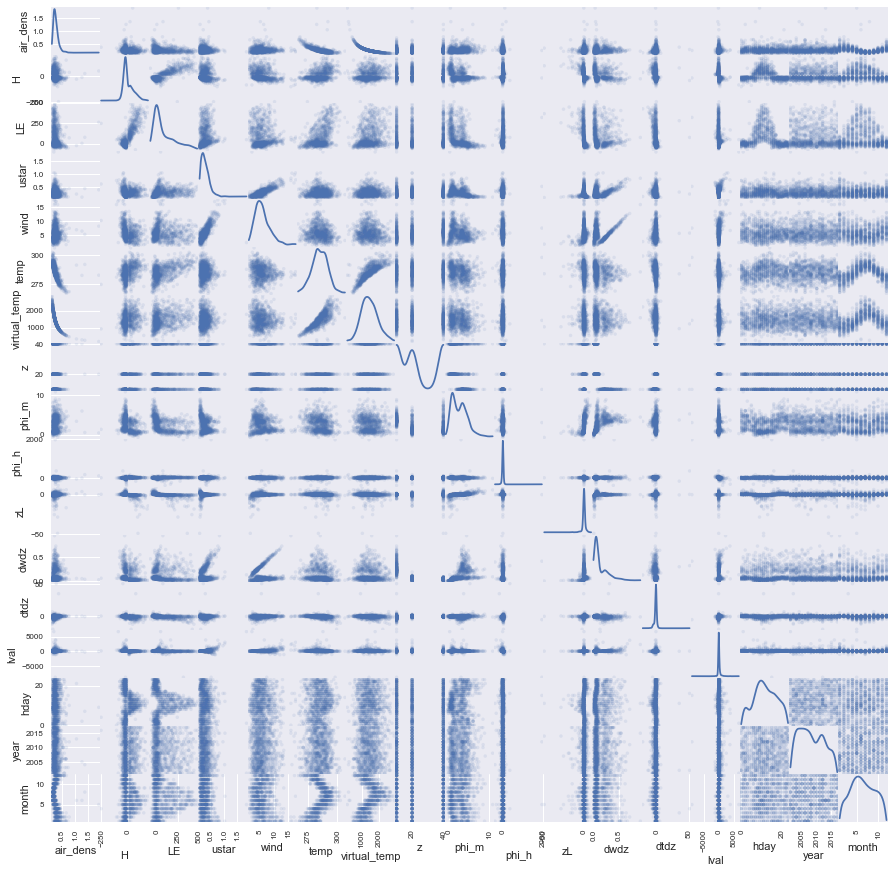

In [18]:
_ = pd.plotting.scatter_matrix(
    df.sample(1000)[measurement_cols + computed_cols + ['hday', 'year', 'month']].drop('soil_temp', axis=1),
    figsize=(15, 15), alpha=0.1, diagonal='kde'
)

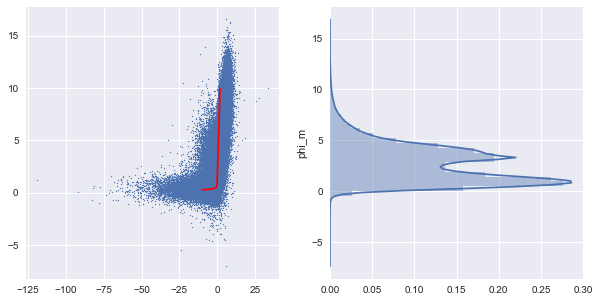

In [19]:
def phi_m(zL):
    if zL < 0:
        return math.pow(1 - 19.3 * zL, -0.25)
    else:
        return 1 + 4.7 * zL


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(df.zL, df.phi_m, s=1)
xx = np.arange(-10, 2, 0.1)
plt.plot(xx, list(map(phi_m ,xx)), 'r')
#plt.xlim(-10, 10)

plt.subplot(1, 2, 2)
sns.distplot(df.phi_m.dropna(), vertical=True)

plt.show()

seems like it's just some constant factor away

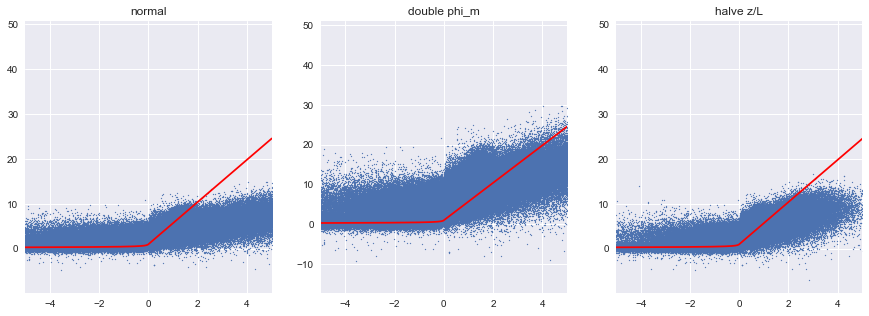

In [47]:
xx = np.arange(-50, 10, 0.01)
phimx = list(map(phi_m ,xx))

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title('normal')
plt.scatter(df.zL, df.phi_m, s=1)
plt.plot(xx, phimx, 'r')
plt.xlim(-5, 5)

plt.subplot(1, 3, 2)
plt.title('double phi_m')
plt.scatter(df.zL, df.phi_m * 2, s=1)
plt.plot(xx, phimx, 'r')
plt.xlim(-5, 5)

plt.subplot(1, 3, 3)
plt.title('halve z/L')
plt.scatter(df.zL / 2, df.phi_m, s=1)
plt.plot(xx, phimx, 'r')
plt.xlim(-5, 5)
plt.show()

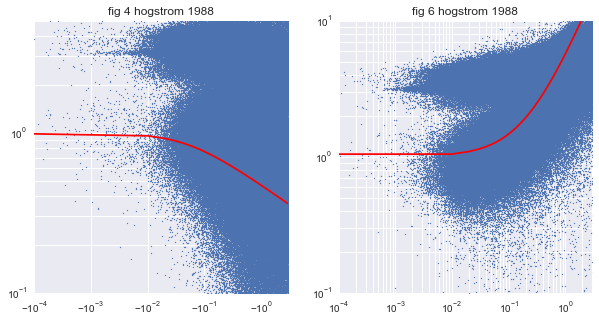

In [53]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(df.zL, df.phi_m, s=1)

plt.plot(xx, phimx, 'r')
plt.xlim(-3, -0.0001)
plt.xscale('symlog', linthreshx=0.0001)
plt.ylim(0.1, 5)
plt.yscale('log')
plt.title('fig 4 hogstrom 1988')
plt.gca().invert_xaxis()
plt.grid(True, 'both')

plt.subplot(1, 2, 2)
plt.scatter(df.zL, df.phi_m, s=1)
plt.plot(xx, phimx, 'r')
plt.xlim(0.0001, 3)
plt.xscale('log')
plt.ylim(0.1, 10)
plt.yscale('log')
plt.title('fig 6 hogstrom 1988')
plt.grid(True, 'both')
plt.show()

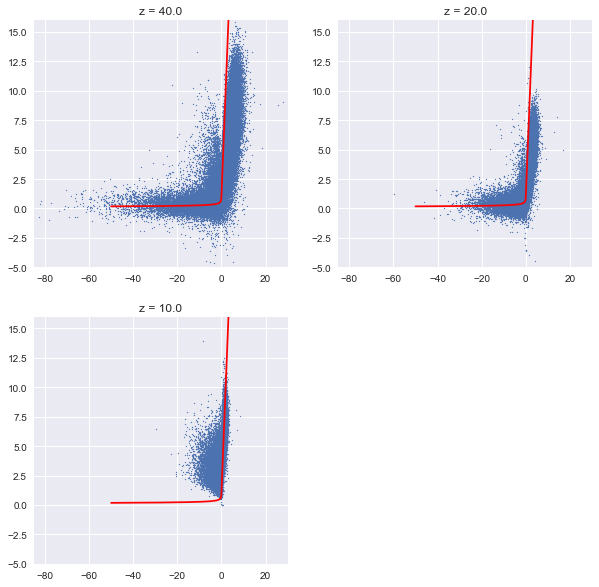

In [22]:
plt.figure(figsize=(10, 10))
for i, z in enumerate(df.z.unique()):
    plt.subplot(2, 2, i + 1)
    plt.title('z = %.1f' % z)
    plt.scatter(df[df.z == z].zL, df[df.z == z].phi_m, s=1)
    plt.plot(xx, phimx, 'r')
    plt.xlim(-85, 30)
    plt.ylim(-5, 16)

    plt.show()

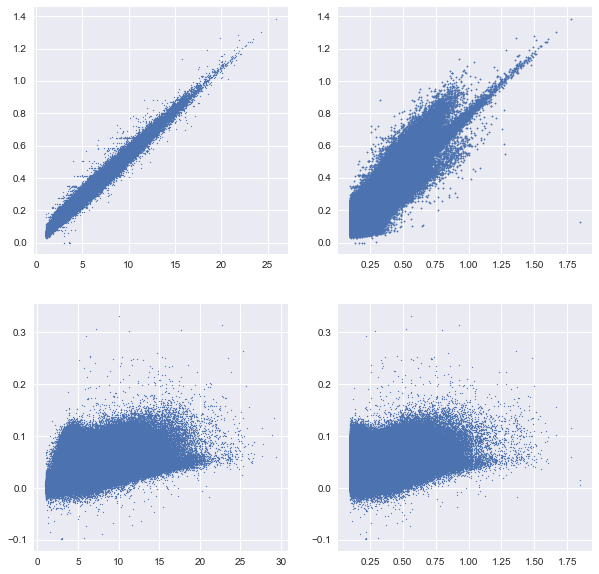

In [45]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.scatter(df[df.z == 10].wind, df[df.z == 10].dwdz, s=1)
plt.subplot(2, 2, 2)
plt.scatter(df[df.z == 10].ustar, df[df.z == 10].dwdz, s=2)
plt.subplot(2, 2, 3)
plt.scatter(df[df.z > 10].wind, df[df.z > 10].dwdz, s=1)
plt.subplot(2, 2, 4)
plt.scatter(df[df.z > 10].ustar, df[df.z > 10].dwdz, s=1)
plt.show()

very different relationship between wind/ustar and dwdz at z=10 and z>10

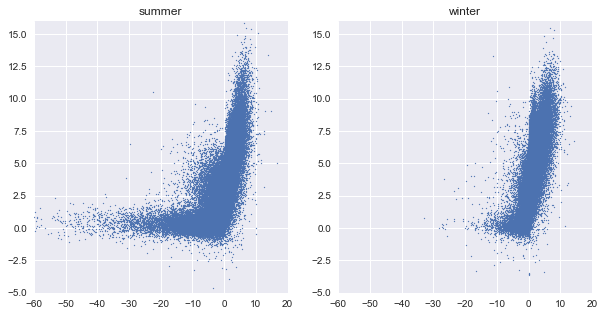

In [23]:
winter = [11, 12, 1, 2]
summer = [6, 7, 8]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('summer')
plt.scatter(df[df.month.isin(summer)].zL, df[df.month.isin(summer)].phi_m, s=1)
plt.xlim(-60, 20)
plt.ylim(-5, 16)

plt.subplot(1, 2, 2)
plt.title('winter')
plt.scatter(df[df.month.isin(winter)].zL, df[df.month.isin(winter)].phi_m, s=1)
plt.xlim(-60, 20)
plt.ylim(-5, 16)
plt.show()

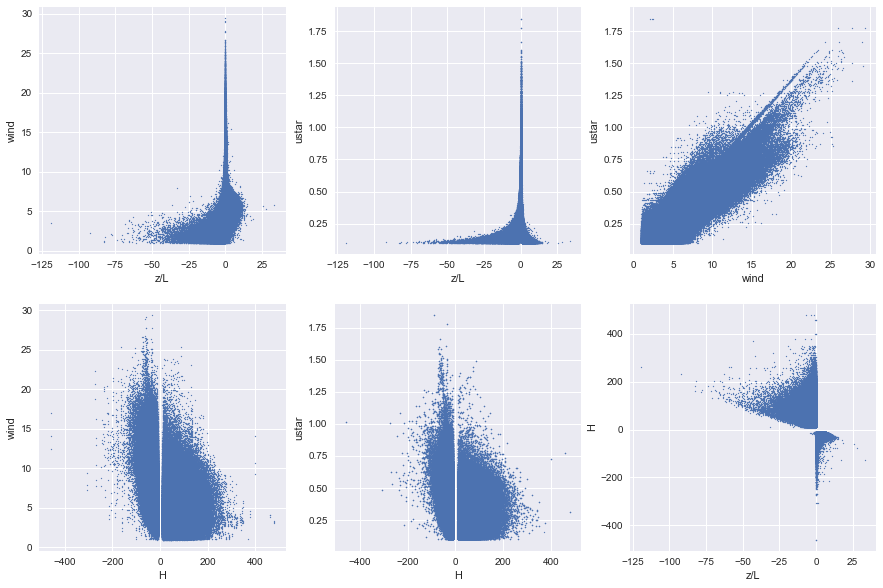

In [24]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 3, 1)
plt.ylabel('wind'); plt.xlabel('z/L')
plt.scatter(df.zL, df.wind, s=1)

plt.subplot(2, 3, 2)
plt.ylabel('ustar'); plt.xlabel('z/L')
plt.scatter(df.zL, df.ustar, s=1)

plt.subplot(2, 3, 3)
plt.scatter(df.wind, df.ustar, s=1)
plt.ylabel('ustar'); plt.xlabel('wind')

plt.subplot(2, 3, 4)
plt.scatter(df.H, df.wind, s=1)
plt.xlabel('H'); plt.ylabel('wind')

plt.subplot(2, 3, 5)
plt.scatter(df.H, df.ustar, s=1)
plt.xlabel('H'); plt.ylabel('ustar')

plt.subplot(2, 3, 6)
plt.scatter(df.zL, df.H, s=1)
plt.ylabel('H'); plt.xlabel('z/L')
plt.show()

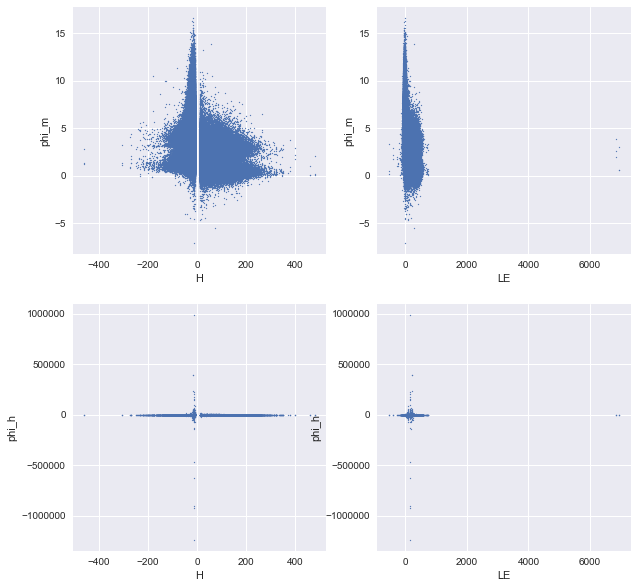

In [54]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1); plt.xlabel('H'); plt.ylabel('phi_m')
plt.scatter(df.H, df.phi_m, s=1)
plt.subplot(2, 2, 2); plt.xlabel('LE'); plt.ylabel('phi_m')
plt.scatter(df.LE, df.phi_m, s=1)
plt.subplot(2, 2, 3); plt.xlabel('H'); plt.ylabel('phi_h')
plt.scatter(df.H, df.phi_h, s=1)
plt.subplot(2, 2, 4); plt.xlabel('LE'); plt.ylabel('phi_h')
plt.scatter(df.LE, df.phi_h, s=1)
plt.show()

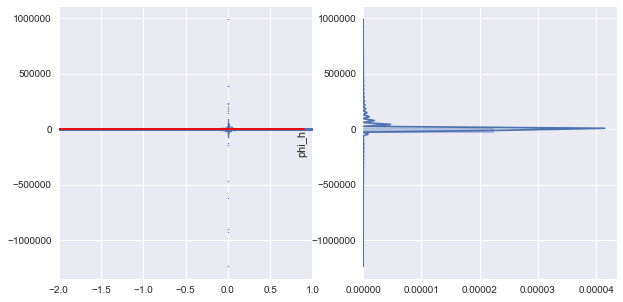

In [26]:
def phi_h(zL):
    if zL < 0:
        return 0.74 * math.pow(1 - 9 * zL, -0.5)
    else:
        return 0.74 + 4.7 * zL

    
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
xx  = np.arange(-2, 1, 0.1)
plt.scatter(df.zL, df.phi_h, s=1)
plt.plot(xx, list(map(phi_h, xx)), 'r')
plt.xlim(-2, 1)

plt.subplot(1, 2, 2)
sns.distplot(df.phi_h.dropna(), vertical=True)
plt.show()

seems wrong. perhaps because I am using measured air temperature and not virtual temperature?

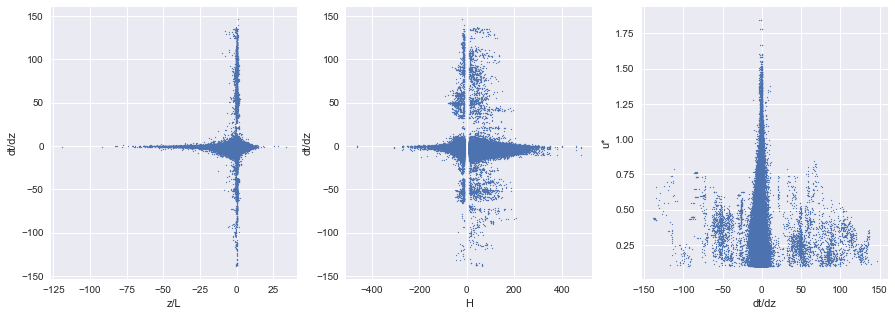

In [27]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.scatter(df.zL, df.dtdz, s=1)
plt.xlabel('z/L'); plt.ylabel('dt/dz')
plt.subplot(1, 3, 2)
plt.scatter(df.H, df.dtdz, s=1)
plt.xlabel('H'); plt.ylabel('dt/dz')
plt.subplot(1, 3, 3)
plt.scatter(df.dtdz, df.ustar, s=1)
plt.xlabel('dt/dz'); plt.ylabel('u*')
plt.show()

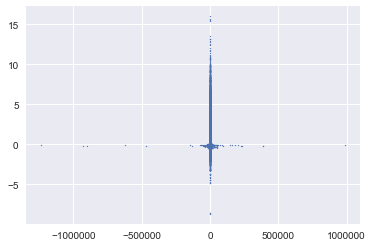

In [28]:
plt.scatter(df.phi_h, df.H / (1005 * df.air_dens * df.ustar), s=1)

## Checking $\phi_m$

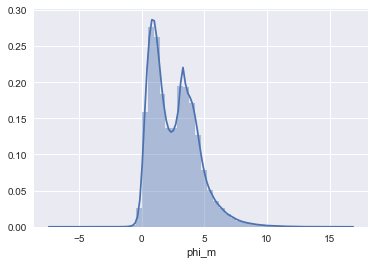

In [29]:
sns.distplot(df.phi_m.dropna())
plt.xlabel('phi_m')
plt.show()

we can compare the CDF of the variables by creating groups based on the range of $\phi_m$. we select the interval (0, 1) because it (supposedly) contains values of phi_m for unstable conditions

In [30]:
ints = [-3, 0, 1, 2, 4, 25]
print('interv.\tcount')
for low, high in zip(ints[:-1], ints[1:]):
    count = len(df[(df.phi_m >= low) & (df.phi_m < high)])
    print('[%d,%d)\t%d' % (low, high, count))

interv.	count
[-3,0)	18874
[0,1)	335272
[1,2)	332395
[2,4)	519436
[4,25)	346414


In [31]:
def plot_cdf(rvars, labels=None, ordinal=False):
    ''' plot the empirical cdf and a boxplot of multple random variables
        in the same chart, to ease comparison

        rvars contains a list of samples for each r.v.
        labels contains a label for each r.v.
    '''
    gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1]) 
    ax1 = plt.subplot(gs[0])

    if ordinal:
        all_levels = sorted(set(v for var in rvars for v in var))
        level_map = dict(zip(all_levels, range(len(all_levels))))
        inv_level_map = dict(zip(range(len(all_levels)), all_levels))
        rvars = [list(map(level_map.get, var)) for var in rvars]

    for i, values in enumerate(rvars):
        xx = sorted(values)
        yy = np.arange(len(values)) / len(values)
        lbl = labels[i] if labels is not None else None
        
        ax1.plot(xx, yy, label=lbl)

    if labels is not None:
        ax1.legend()

    ax2 = plt.subplot(gs[1])
    sns.boxplot(data=rvars, ax=ax2, orient='h')

    if ordinal:
        ticklb = [
            # ticks are float, get label only on integral ticks
            (inv_level_map.get(int(t), '') if abs(int(t) - t) < 1e-9 else '')
            for t in ax1.get_xticks()
        ]

        ax1.set_xticklabels(ticklb)
        ax2.set_xticklabels(ticklb)

    return ax1, ax2


def inspect_col(colname, partition_by, interval, show=True, fig=None):
    old_pal = sns.color_palette()
    sns.set_palette('GnBu_d')

    vs = [
        df[colname][
            (df[partition_by] >= low) &
            (df[partition_by] < high)
        ].dropna()
        for low, high in zip(interval[:-1], interval[1:])
    ]

    if fig is None:
        fig = plt.figure(figsize=(7, 5))

    ax1, ax2 = plot_cdf(
        vs, list(map(str, zip(interval[:-1], interval[1:]))),
        ordinal=colname in source_cols + ['ds']
    )
    ax1.set_title(colname)
    sns.set_palette(old_pal)
    
    if show:
        plt.show()
    
    return fig, ax1, ax2

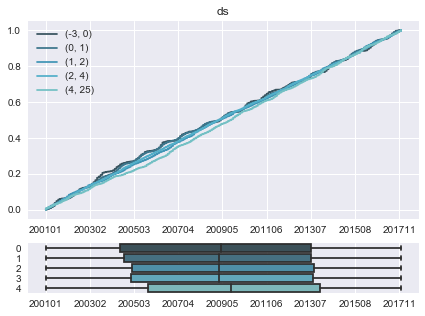

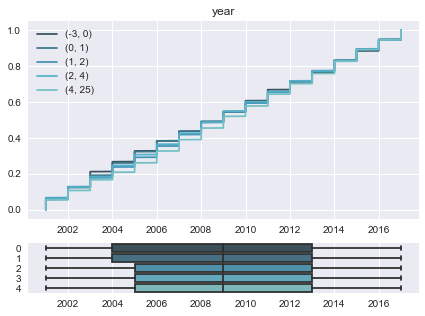

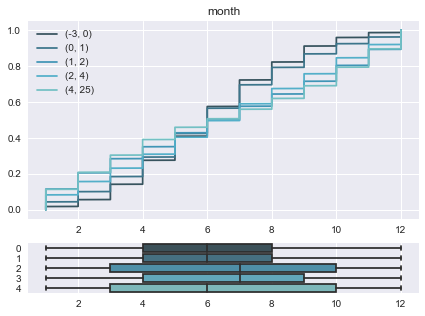

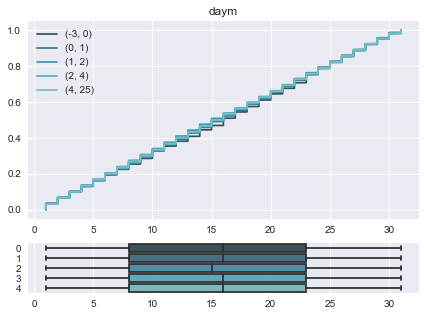

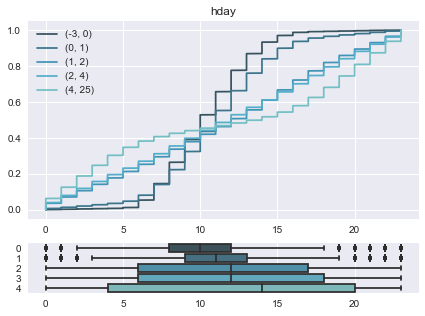

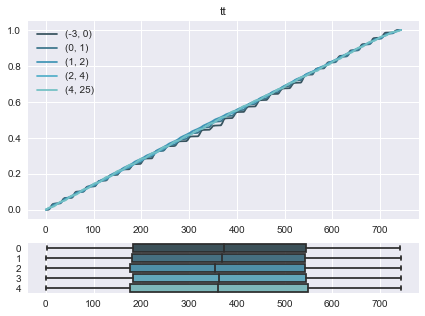

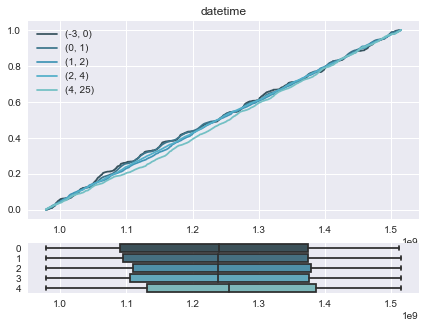

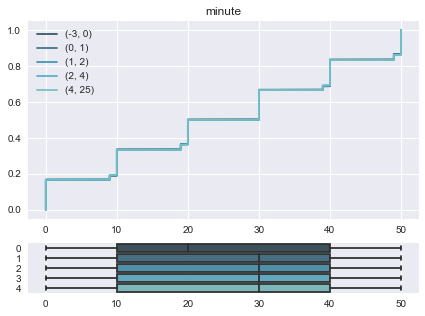

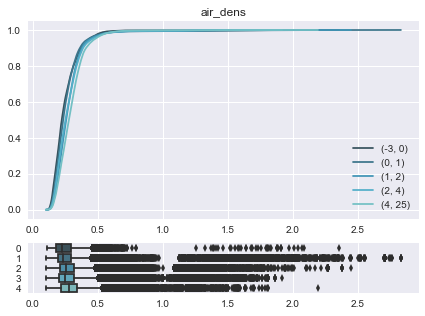

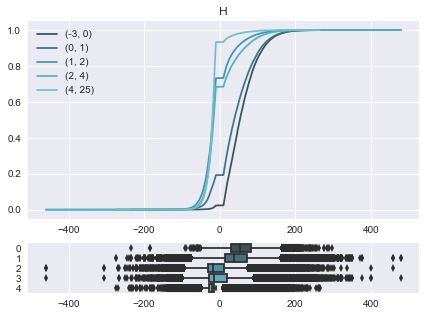

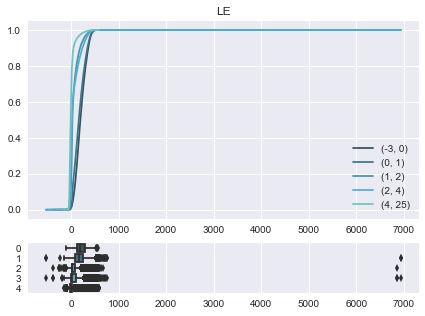

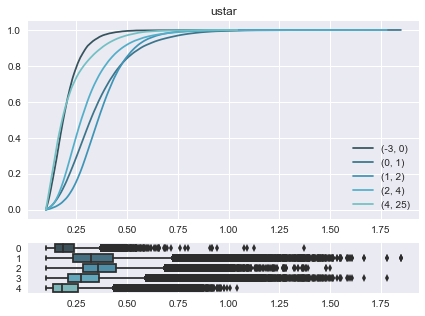

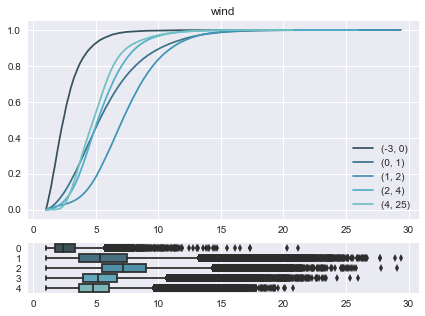

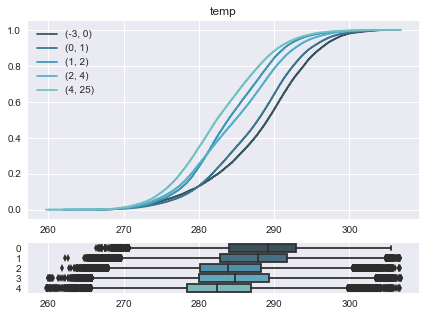

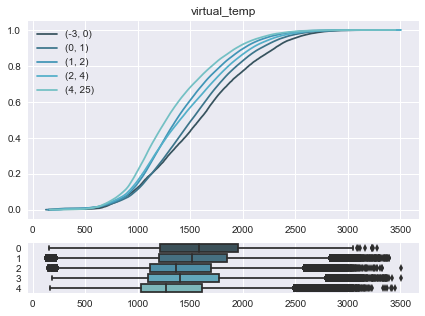

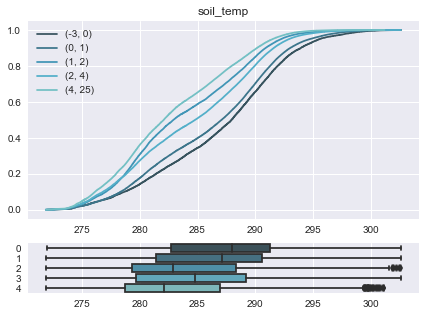

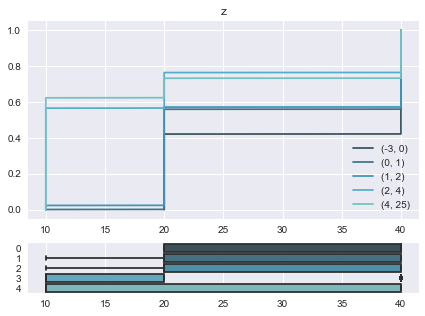

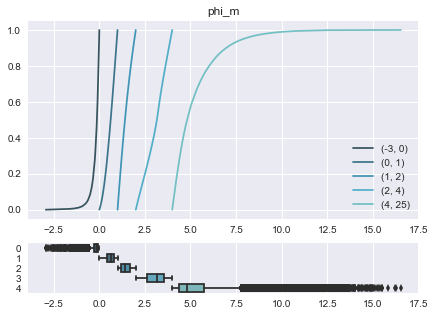

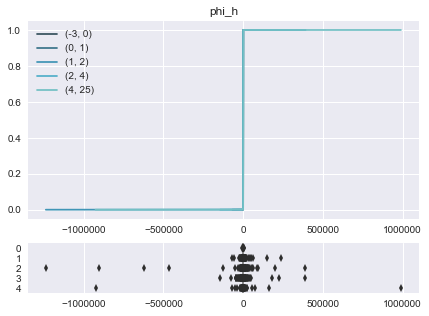

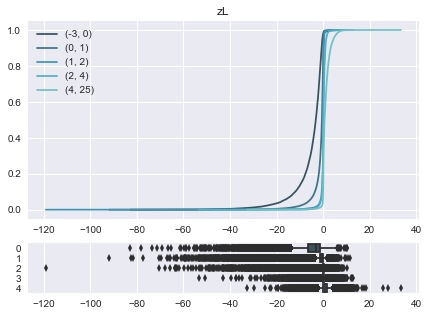

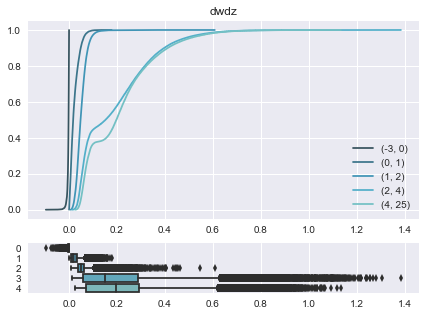

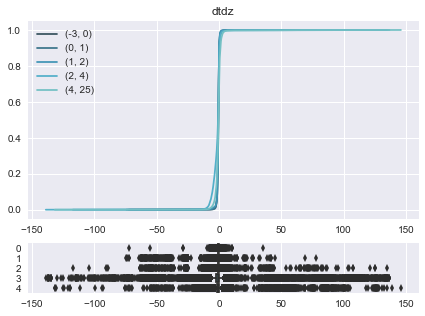

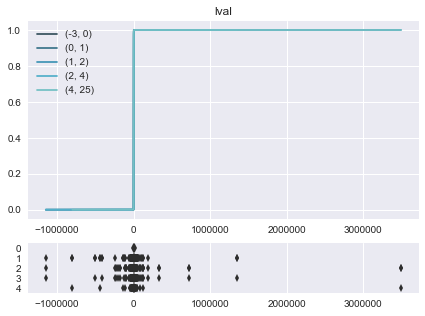

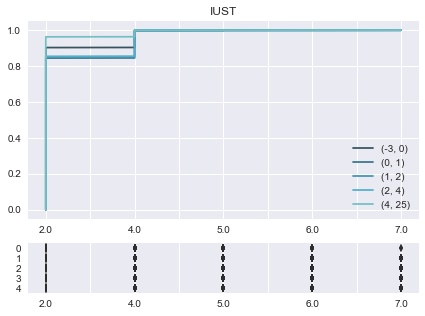

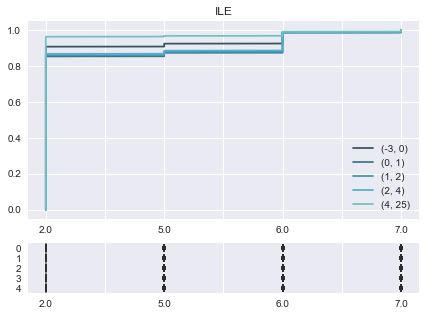

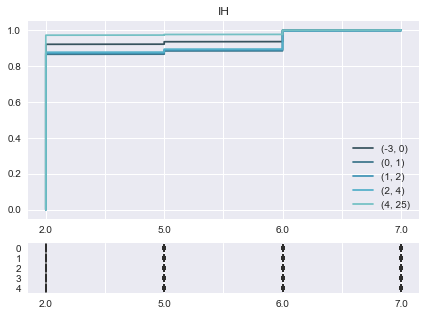

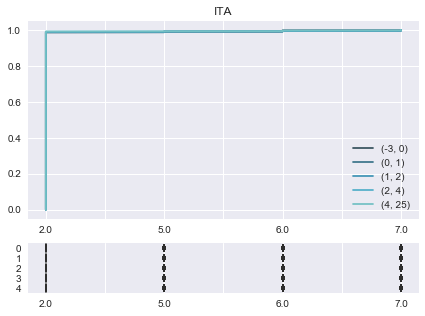

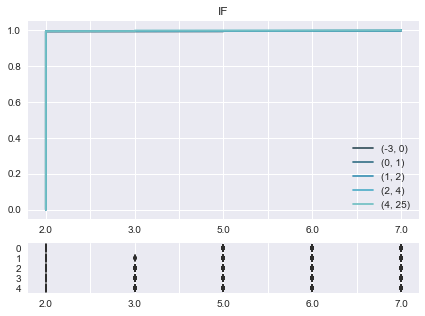

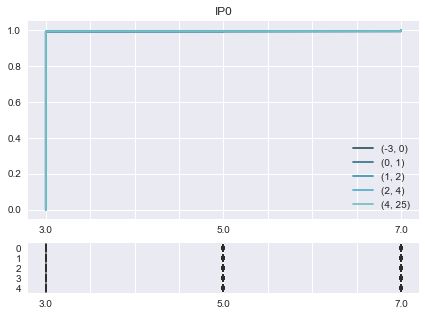

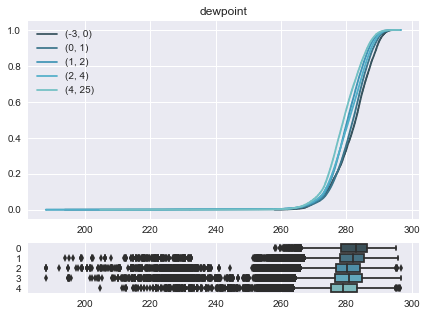

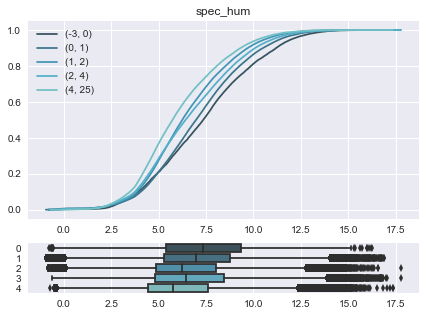

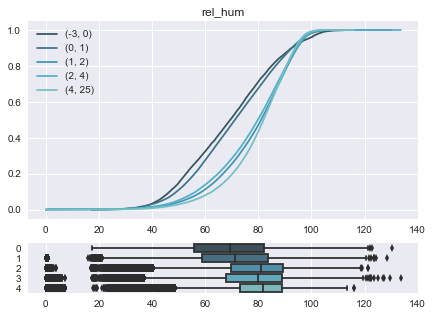

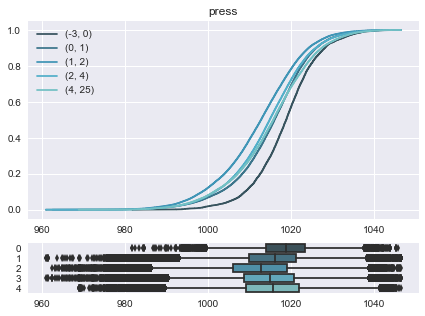

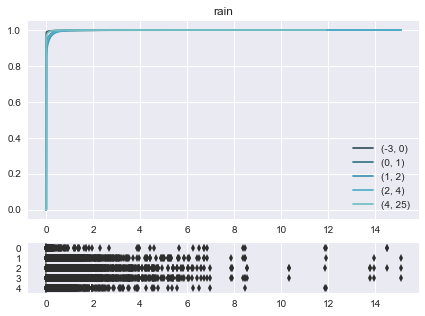

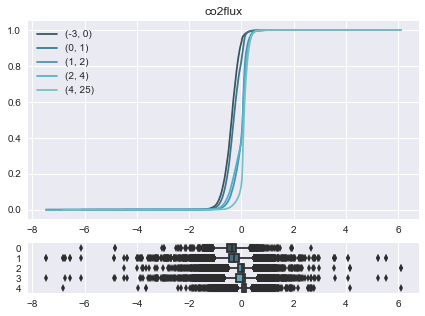

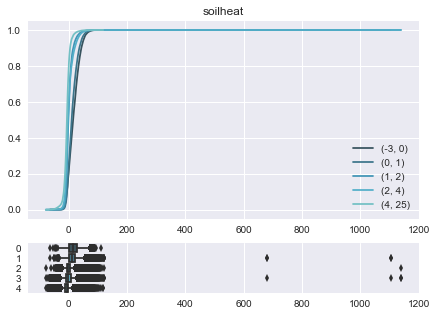

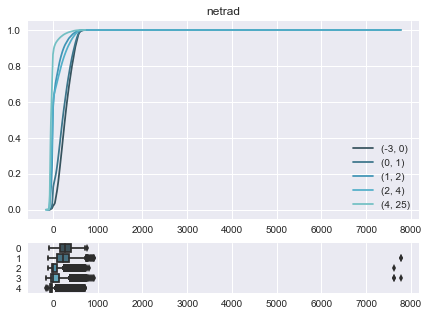

In [32]:
for col in df.columns:
    inspect_col(col, 'phi_m', ints)

seems like the source of the data (I-columns) does not play a big role in differentiating the phi levels

we see larger $\phi_m$s associated with
 - denser air
 - colder surface temperature
 - more wind
 - larger and mostly positive temperature gradient
 - lower heat fluxes

this is consistent with what we would expect, as $\phi_m$ is expected to be higher in stable condtions

highest $u_*$ in moderately stable conditions, low values in unstable and highly stable conditions; this makes sense, because in unstable conditions most tke comes from eddy fluxes caused by buoyancy, and in very stable conditions we have a calm surface layer with little turbulence. in both cases wind shear does not generate much turbulence

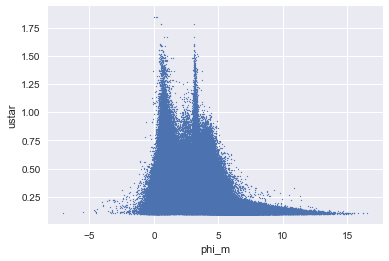

In [33]:
df.plot.scatter('phi_m', 'ustar', s=1)

seems like the 6 days seasonality does not depend on the year nor on the month of the year, if we take into account the fact that some months have way more measures than others

what bothers me is that this 6 days cycle repeats more or less regularly for more than 15 years

<Container object of 40 artists>

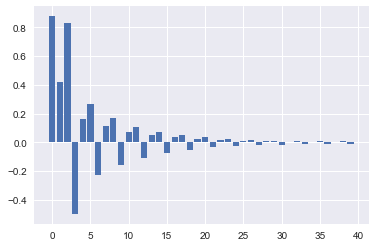

In [34]:
vs = pacf(df.sort_values(['ds', 'tt']).wind)
plt.bar(range(len(vs) - 1), vs[1:])

## inspect z/L (for phi_m)

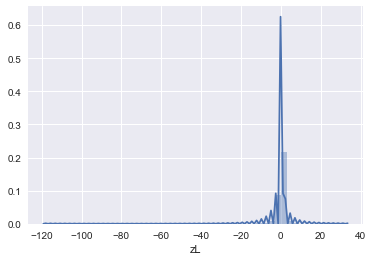

In [35]:
sns.distplot(df.zL)

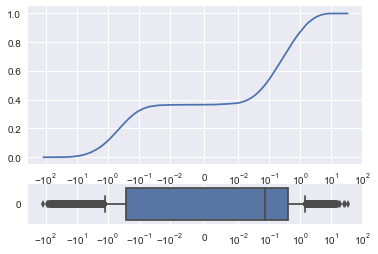

In [36]:
ax1, ax2 = plot_cdf([df.zL], labels=None)
ax1.set_xscale('symlog', linthreshx=1e-2)
ax2.set_xscale('symlog', linthreshx=1e-2)

In [37]:
bins = [
    -120, -1, 0, 1, 50
]

(df.zL.groupby(np.digitize(df.zL, bins))
     .size().rename(lambda b: '[%6.0e, %6.0e)' % (bins[b - 1], bins[b])))

[-1e+02, -1e+00)    176287
[-1e+00,  0e+00)    390887
[ 0e+00,  1e+00)    790586
[ 1e+00,  5e+01)    194660
Name: zL, dtype: int64

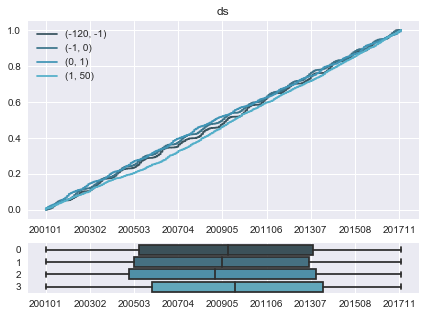

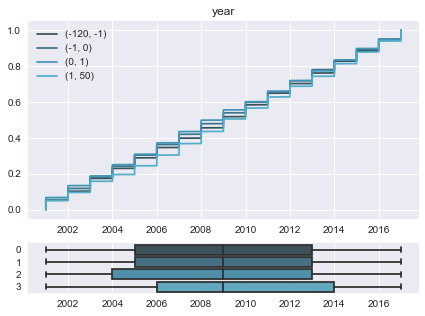

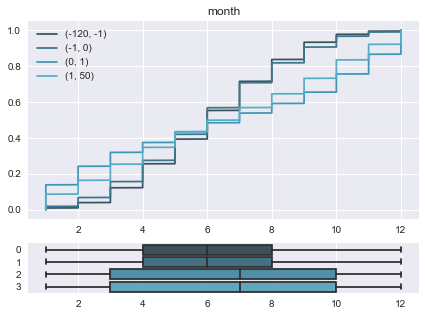

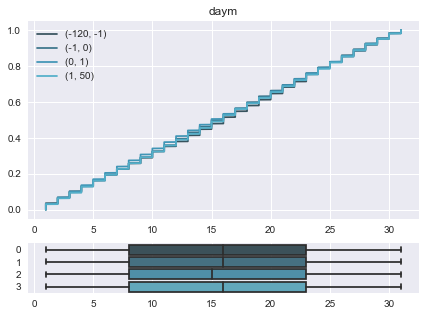

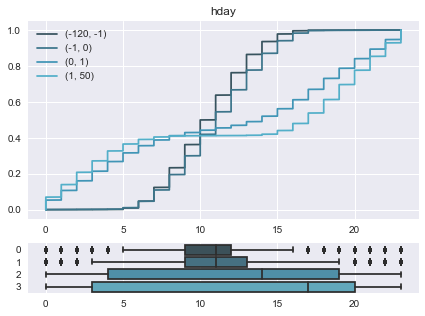

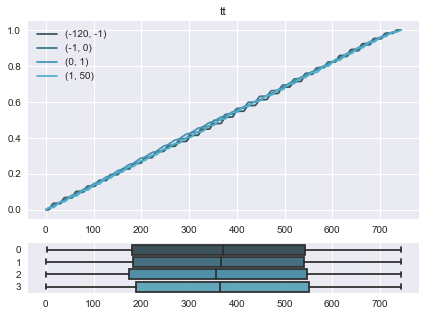

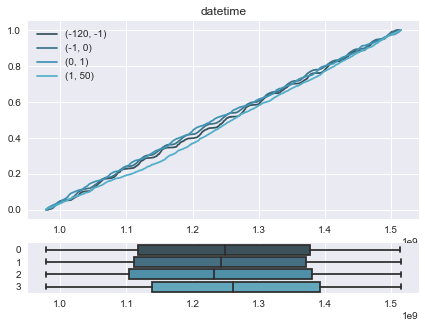

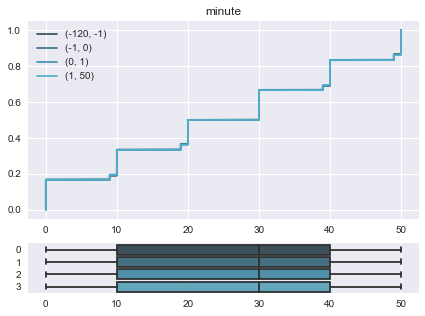

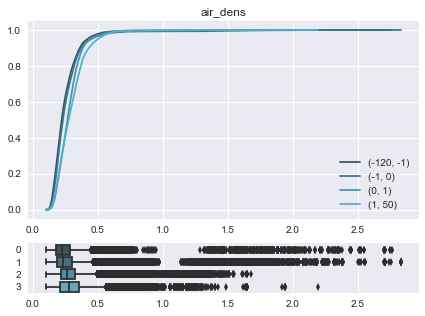

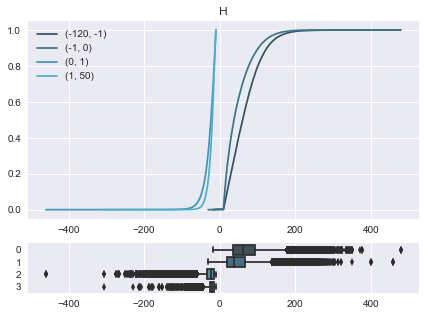

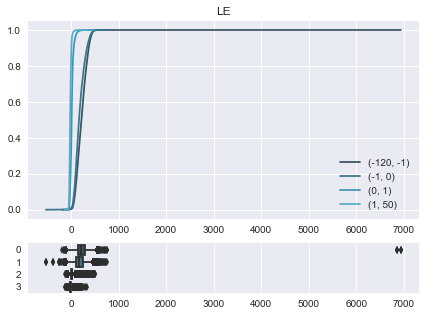

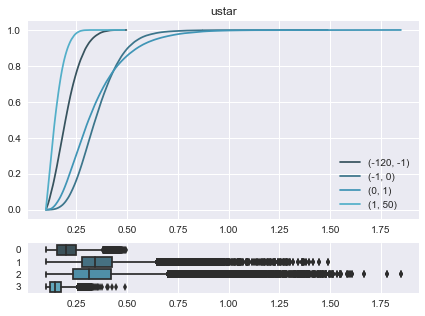

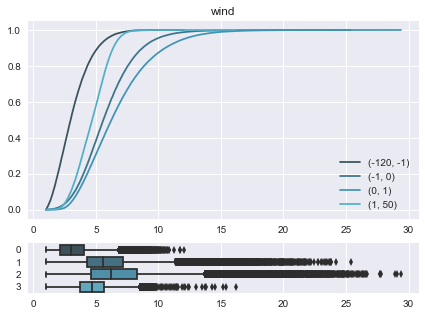

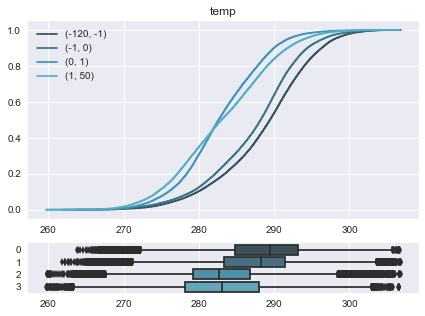

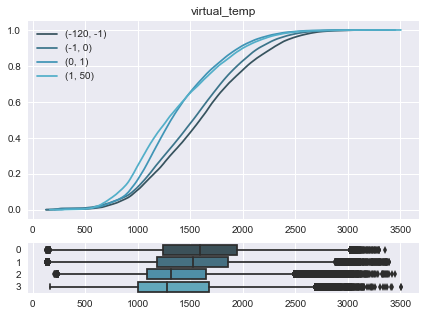

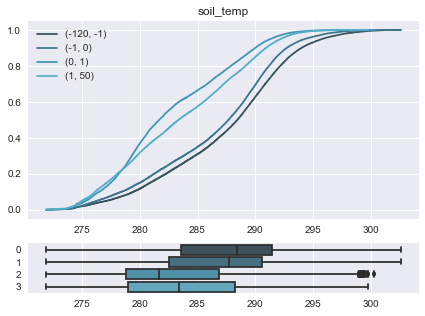

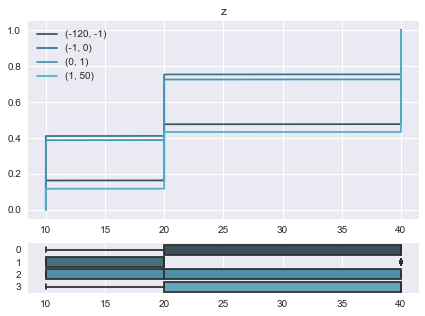

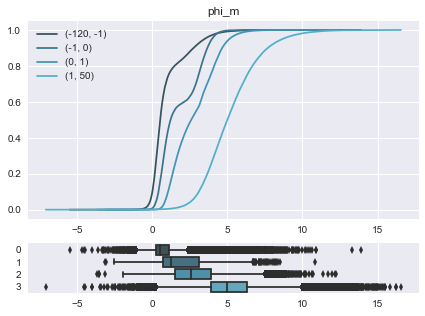

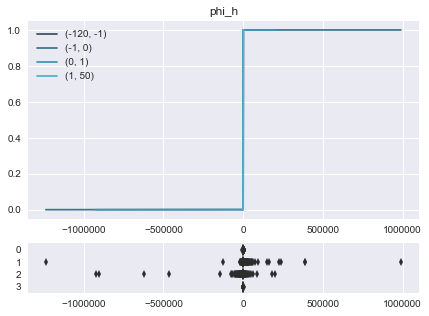

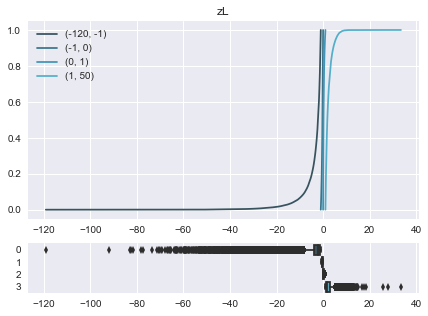

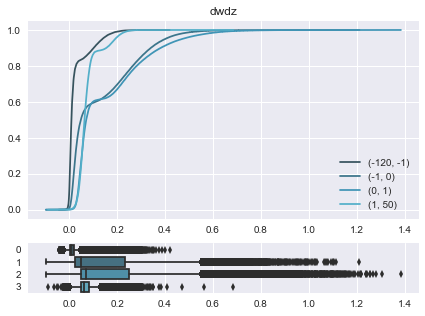

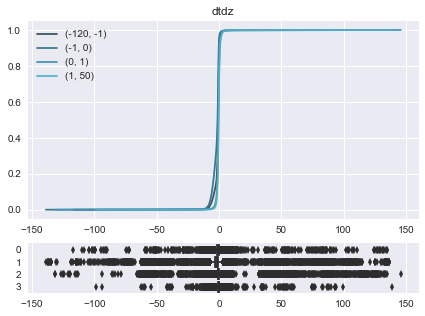

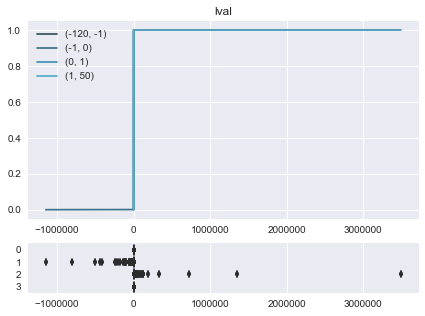

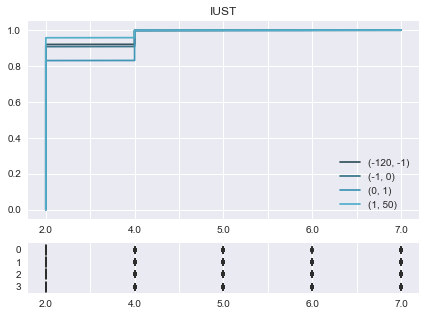

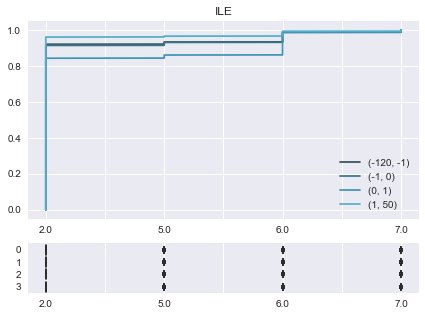

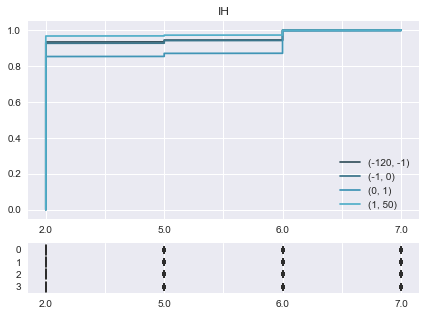

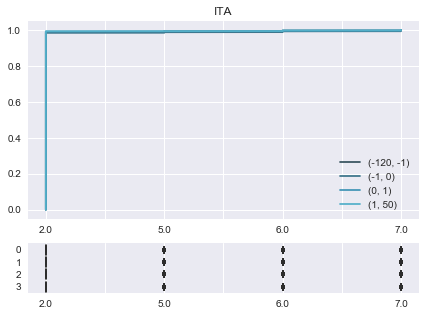

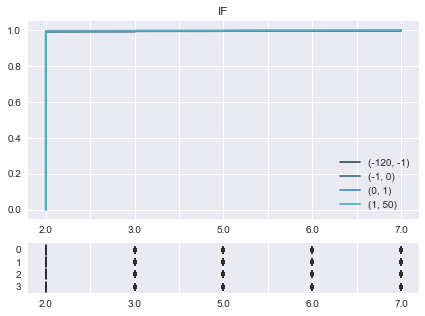

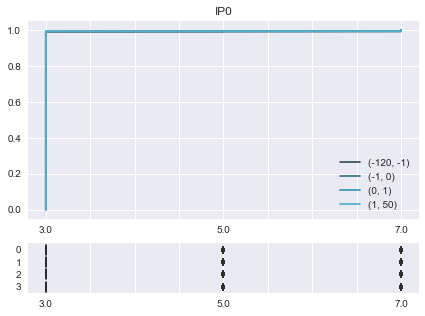

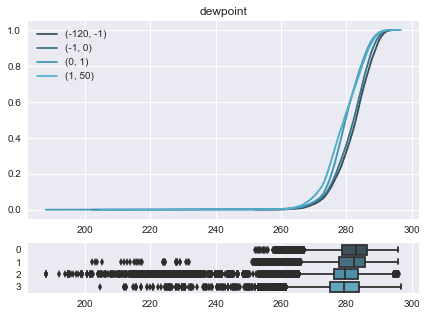

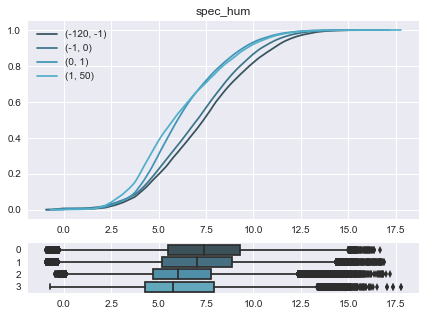

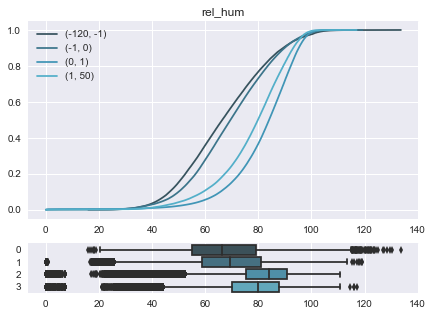

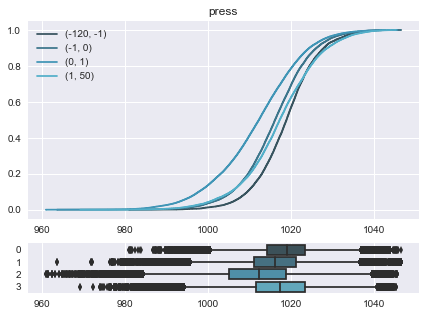

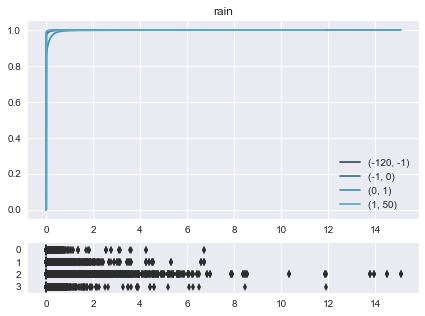

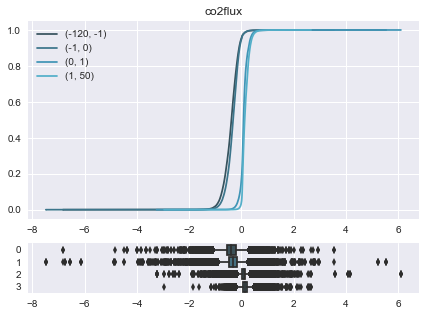

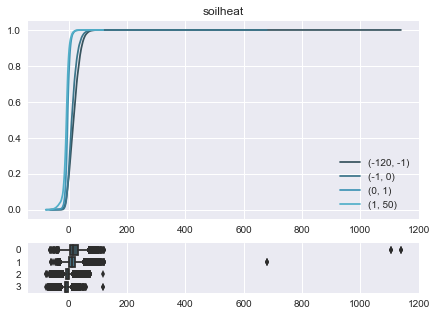

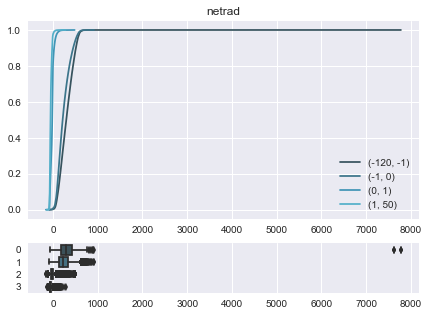

In [38]:
for col in df.columns:
    inspect_col(col, 'zL', bins)

In [39]:
(df.groupby(np.digitize(df.zL, bins))
     [['ustar', 'wind', 'LE', 'temp', 'phi_m']].mean()
     .rename(lambda b: '[%6.0f, %6.0f)' % (bins[b - 1], bins[b])))

,ustar,wind,LE,temp,phi_m
"[ -120, -1)",0.206013,3.205570,220.003459,288.704638,0.941135
"[ -1, 0)",0.357645,5.864532,181.544207,287.337700,1.826083
"[ 0, 1)",0.344723,6.728101,12.771379,282.893281,2.774353
"[ 1, 50)",0.152405,4.703470,-20.926398,283.130343,5.236304
